In [8]:
!pip install efficientnet_pytorch torch torchvision matplotlib scikit-learn


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=cc2e0154eced81d206b5950ca8ebcfe7ced2eca9a8f74a5d5af8cbfce7b3cf77
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet_pytorch


In [9]:
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from shutil import copy2


In [13]:
from google.colab import files
uploaded = files.upload()  # Select the dataset ZIP file from your local machine here


Saving archive (1).zip to archive (1).zip


In [16]:
!unzip -q "archive (1).zip" -d /content/


In [23]:
import os
print(os.listdir('/content/dataset'))


['.directory', 'sub', '5', 'add', 'z', 'eq', '6', 'mul', '9', '7', '4', '2', '3', 'x', '0', 'y', '8', '1', 'div', 'dec']


In [25]:
src_datadir = "/content/archive/dataset"
import shutil
shutil.rmtree('/content/datasplit', ignore_errors=True)


In [26]:
import os
import random
from shutil import copy2

random.seed(42)
src_datadir = "/content/dataset"     # <-- THIS is the correct dataset root!
dstroot = "/content/datasplit"
trainroot = os.path.join(dstroot, "train")
valroot = os.path.join(dstroot, "val")
testroot = os.path.join(dstroot, "test")

os.makedirs(trainroot, exist_ok=True)
os.makedirs(valroot, exist_ok=True)
os.makedirs(testroot, exist_ok=True)

classes = [cls for cls in os.listdir(src_datadir) if os.path.isdir(os.path.join(src_datadir, cls)) and not cls.startswith('.')]
print('Classes found:', classes)

for cls in classes:
    srccls = os.path.join(src_datadir, cls)
    images = [f for f in os.listdir(srccls) if os.path.isfile(os.path.join(srccls, f))]
    random.shuffle(images)
    n = len(images)
    ntrain = int(0.7 * n)
    nval = int(0.15 * n)

    trainimgs = images[:ntrain]
    valimgs = images[ntrain:ntrain+nval]
    testimgs = images[ntrain+nval:]

    for split_dir, imgs in zip([trainroot, valroot, testroot], [trainimgs, valimgs, testimgs]):
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)
        for img in imgs:
            copy2(os.path.join(srccls, img), os.path.join(split_dir, cls, img))

print("Data split complete!")


Classes found: ['sub', '5', 'add', 'z', 'eq', '6', 'mul', '9', '7', '4', '2', '3', 'x', '0', 'y', '8', '1', 'div', 'dec']
Data split complete!


In [27]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

datadir = "/content/datasplit"

train_data = datasets.ImageFolder(os.path.join(datadir, 'train'), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(datadir, 'val'), transform=val_test_transforms)
test_data = datasets.ImageFolder(os.path.join(datadir, 'test'), transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")
print("Classes:", train_data.classes)


Train size: 7040
Validation size: 1501
Test size: 1530
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub', 'x', 'y', 'z']


In [28]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

num_features = model._fc.in_features
num_classes = len(train_data.classes)

# Modify the final fully connected layer
model._fc = nn.Linear(num_features, num_classes)

# Only train the final fc layer
for param in model._fc.parameters():
    param.requires_grad = True

model = model.to(device)
print(model)


Using device: cuda
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


100%|██████████| 20.4M/20.4M [00:00<00:00, 106MB/s] 


Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [29]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model._fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [30]:
num_epochs = 15
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        if i % 10 == 0:
            print(f"Epoch {epoch+1} Batch {i+1}/{len(train_loader)} Loss: {loss.item():.4f}")

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")
    scheduler.step()


Epoch 1 Batch 1/220 Loss: 2.9372
Epoch 1 Batch 11/220 Loss: 2.6237
Epoch 1 Batch 21/220 Loss: 2.1195
Epoch 1 Batch 31/220 Loss: 1.9865
Epoch 1 Batch 41/220 Loss: 1.8621
Epoch 1 Batch 51/220 Loss: 1.6956
Epoch 1 Batch 61/220 Loss: 1.4617
Epoch 1 Batch 71/220 Loss: 1.2441
Epoch 1 Batch 81/220 Loss: 1.2558
Epoch 1 Batch 91/220 Loss: 1.3210
Epoch 1 Batch 101/220 Loss: 1.2338
Epoch 1 Batch 111/220 Loss: 1.0447
Epoch 1 Batch 121/220 Loss: 0.6480
Epoch 1 Batch 131/220 Loss: 1.1234
Epoch 1 Batch 141/220 Loss: 0.9787
Epoch 1 Batch 151/220 Loss: 0.8452
Epoch 1 Batch 161/220 Loss: 0.8625
Epoch 1 Batch 171/220 Loss: 0.8532
Epoch 1 Batch 181/220 Loss: 0.7164
Epoch 1 Batch 191/220 Loss: 0.7885
Epoch 1 Batch 201/220 Loss: 0.7475
Epoch 1 Batch 211/220 Loss: 0.6345
Epoch 1/15 Train Loss: 1.2359 Val Loss: 1.2369 Val Acc: 73.28%
Epoch 2 Batch 1/220 Loss: 0.6892
Epoch 2 Batch 11/220 Loss: 0.4761
Epoch 2 Batch 21/220 Loss: 0.5741
Epoch 2 Batch 31/220 Loss: 0.6575
Epoch 2 Batch 41/220 Loss: 0.4609
Epoch 2 B

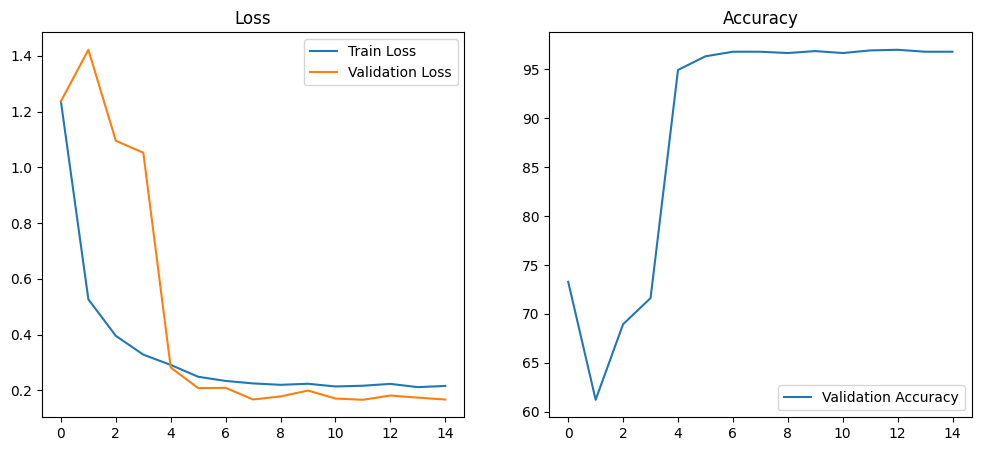

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 95.56%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        90
           1       0.99      0.96      0.98        85
           2       0.93      0.85      0.89        66
           3       0.89      0.96      0.92        82
           4       0.95      0.91      0.93        80
           5       0.95      0.83      0.89        66
           6       0.92      0.95      0.94        88
           7       0.93      0.93      0.93        81
           8       0.95      0.98      0.96        84
           9       0.96      0.96      0.96        83
         add       0.94      0.97      0.95        90
         dec       1.00      0.99      0.99        95
         div       0.99      0.97      0.98        94
          eq       0.97      1.00      0.98        96
         mul       0.97      0.98      0.97        88
         sub       1.00      0.99      0.99        99
           x       0.92      0.97   

In [33]:
torch.save(model.state_dict(), "efficientnet_math_symbols_weights.pth")
torch.save(model, "efficientnet_math_symbols_full_model.pth")
print("Model weights and full model saved!")


Model weights and full model saved!
